# Notebook to create the Cross-Validation-Setup & train a first model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import cv2
from glob import glob
import os
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from copy import deepcopy
import segmentation_models_pytorch as smp
from torchinfo import summary
import random
from copy import deepcopy
import albumentations as A


In [2]:
name = '1_Baseline_2DCNN'
depth = 5
size = 224

In [3]:
folder = '/home/olli/Projects/Kaggle/Vesuvius'

In [4]:
folder_data = os.path.join(folder, 'Data', 'Preprocessed', 'Cropped_Regions')

In [5]:
files = glob(folder_data + '/*.pickle')

In [6]:
len(files)

137

In [7]:
#sort them in the correct order to later get the same results
files.sort()

# 1) Create 5 folds from the 137 cropped parts

In [8]:
def create_folds(files):
    
    files_copy = deepcopy(files)
    
    # shuffle them with the same random seed to get identical results
    random.Random(42).shuffle(files_copy)
    
    # each fold will consist of 27, 27, 27, 28, 28 files
    num_per_fold = [27, 27, 27, 28, 28]
    folds = [f'fold_{i}' for i in range(5)]
    
    for num, fold in zip(num_per_fold, folds):
        globals()[fold] = files_copy[:num]  # assign the first num elements to the current fold
        del files_copy[:num]  # now remove them from the list
        
    folds = [fold_0, fold_1, fold_2, fold_3, fold_4]
    
    if len(files_copy) == 0:
        print('All scans assinged to their folds')
    
    return folds

In [9]:
folds = create_folds(files=files)

All scans assinged to their folds


In [10]:
[len(i) for i in folds]

[27, 27, 27, 28, 28]

In [11]:
folds[0][0]

'/home/olli/Projects/Kaggle/Vesuvius/Data/Preprocessed/Cropped_Regions/1_5.pickle'

# 2) From these 5 folds create the 5 train and valid folds

In [12]:
def create_train_valid(folds):
    
    train_folds = [f'train_{i}' for i in range(5)]
    valid_folds = [f'valid_{i}' for i in range(5)]
    
    # each time one unique fold is the validation-data and the rest is for training
    for i in range(5):
        folds_copy = deepcopy(folds)
        
        globals()[valid_folds[i]] = folds_copy.pop(i)  # current for for validation
        
        train = []  # append the 4 remaining 4 folds to the current train data
        for fold in folds_copy:
            train += fold
            
        # finally assing it to the variable
        globals()[train_folds[i]] = train
        
    train_data = [train_0, train_1, train_2, train_3, train_4]
    valid_data = [valid_0, valid_1, valid_2, valid_3, valid_4]
    
    return train_data, valid_data

In [13]:
train_data, valid_data = create_train_valid(folds=folds)

In [14]:
[len(i) for i in train_data]

[110, 110, 110, 109, 109]

In [15]:
[len(i) for i in valid_data]

[27, 27, 27, 28, 28]

In [16]:
# make sure there is no validation data in the corresponding train data

for i in range(5):
    val = valid_data[i]
    train = train_data[i]
    
    for file in val:
        if file in train:
            print(f'DUBLICATE: {file}')

# 3) Now create a model a simple 2D CNN for this segmentation task

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
model = smp.Unet(
    encoder_name='se_resnext50_32x4d',  # backbone encoder
    encoder_weights=None,  # train from scratch
    in_channels=5,  # input channels equals the depth, i.e. layer
    classes=1,  # only 1 class (ink or no ink)
)

In [19]:
summary(model, input_data=torch.randn(1, depth, size, size))

Layer (type:depth-idx)                             Output Shape              Param #
Unet                                               [1, 1, 224, 224]          --
├─SENetEncoder: 1-1                                [1, 5, 224, 224]          --
│    └─Sequential: 2-1                             --                        --
│    │    └─Conv2d: 3-1                            [1, 64, 112, 112]         15,680
│    │    └─BatchNorm2d: 3-2                       [1, 64, 112, 112]         128
│    │    └─ReLU: 3-3                              [1, 64, 112, 112]         --
│    │    └─MaxPool2d: 3-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-2                             [1, 256, 56, 56]          --
│    │    └─SEResNeXtBottleneck: 3-5               [1, 256, 56, 56]          71,952
│    │    └─SEResNeXtBottleneck: 3-6               [1, 256, 56, 56]          79,632
│    │    └─SEResNeXtBottleneck: 3-7               [1, 256, 56, 56]          79,632
│    └─Sequential:

In [20]:
model.decoder

UnetDecoder(
  (center): Identity()
  (blocks): ModuleList(
    (0): DecoderBlock(
      (conv1): Conv2dReLU(
        (0): Conv2d(3072, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (attention1): Attention(
        (attention): Identity()
      )
      (conv2): Conv2dReLU(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (attention2): Attention(
        (attention): Identity()
      )
    )
    (1): DecoderBlock(
      (conv1): Conv2dReLU(
        (0): Conv2d(768, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inpla

### The model has no sigmoid activation as output so use BCELossWithLogits

In [21]:
with torch.no_grad():
    print(model(torch.randn(1, depth, size, size).to(device)).size())

torch.Size([1, 1, 224, 224])


### Now save the initial weights to start a new model by loading these

In [22]:
def save_weights(model):
    name = 'UNET_random_weights.pth'
    
    path_weight = os.path.join(folder, 'Weights', name)
    
    if not os.path.exists(path_weight):
        
        torch.save(model.state_dict(), path_weight)

In [23]:
save_weights(model=model)

# 4) Now define the functions to train and evaluate a model

In [24]:
def train_model(model, optimizer, loss, X, y):
    model.train()
    
    pred = model(X)
    
    # add the class dimension in the correct place (batch, size, size -> batch, classes, size, size)
    y = y.unsqueeze(1)
    
    batch_loss = loss(pred, y)
    
    batch_loss.backward()
    
    optimizer.step()
    
    optimizer.zero_grad()
    
    return batch_loss.item()

In [25]:
@torch.no_grad()
def valid_loss(model, optimizer, loss, X, y):
    model.eval()
    
    pred = model(X)
    
    y = y.unsqueeze(1)
    
    batch_loss = loss(pred, y)
    
    return batch_loss.item()

In [26]:
def calculate_dice(pred, y, beta=0.5, smooth=1e-5):

    pred = torch.sigmoid(pred)  # model has no sigmoid (bcelosswithlogits)

    # create a single dimension float vector
    pred = pred.view(-1).float()
    y = y.view(-1).float()

    y_true_count = y.sum()
    ctp = pred[y==1].sum()
    cfp = pred[y==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice_score = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice_score

In [27]:
@torch.no_grad()
def eval_dice(model, X, y):
    model.eval()
    
    pred = model(X)
    
    y = y.unsqueeze(1)
    
    dice_score = calculate_dice(pred, y)
    
    return dice_score.item()

# 5) Define the augmentations (use albumentations with mask!)

In [28]:
# start only with minor augmentations
augmentations_train = A.Compose([
    A.Resize(size, size),
    #A.RandomResizedCrop(height=1024, width=1024, scale=(0.75, 1)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    #A.Rotate(limit=20, p=0.8, border_mode=cv2.BORDER_CONSTANT),
    #A.GaussNoise(p=0.8),
    #A.ElasticTransform(p=0.8),
    A.Normalize(mean=[0.5] * depth, std=[0.5] * depth)  # value for each layer
])

In [29]:
# use augmentations on validation data only as resizing/normalization
augmentations_valid = A.Compose([
    A.Resize(size, size),
    A.Normalize(mean=[0.5] * depth, std=[0.5] * depth)  # value for each layer
])

# 6) Dataset and DataLoader

In [30]:
# gets initialized with the paths from the corresponding five train/valid datasets

class Data(Dataset):
    def __init__(self, paths, transform=False):
    
        self.paths = paths
        random.shuffle(self.paths)
        
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index]
        
        with open(path, 'rb') as f:
            data = pickle.load(f)
            
        X, y = data
        
        X = X[:, :, :depth]  # 5 layers as defined
        
        # transform the image as well as the label
        if self.transform:
            augmentation = self.transform(image=X, mask=y)
            
            X = augmentation['image']
            y = augmentation['mask']

        X = torch.tensor(X)
        
        X = X.permute(2, 0, 1).type(torch.float32)
        
        y = y / 255.
        y = torch.tensor(y).float()
        
        return X, y

# 7) Train/Validate 5 models on their data

In [31]:
%%time

num_epochs = 20
learning_rate = 5e-4
batch_size = 32

df = pd.DataFrame()  # empty dataframe to store all the metrics

for i in range(5):
    
    # for each model load the random weights to start again
    path_random_weights = os.path.join(folder, 'Weights', 'UNET_random_weights.pth')
    model.load_state_dict(torch.load(path_random_weights))
    
    # get the current datasets
    train = train_data[i]
    valid = valid_data[i]
    
    # create a train and valid dataset
    train_ds = Data(paths=train, transform=augmentations_train)
    valid_ds = Data(paths=valid, transform=augmentations_valid)
    
    # create the dataloaders for both datasets
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=16)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=10)
    
    # define the loss
    bce_loss = nn.BCEWithLogitsLoss()  # ToDo: Weights for both classes
    
    # define an optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # to later plot the metrics put them in a list after each epoch
    epoch_train_loss, epoch_valid_loss = [], []
    epoch_train_dice, epoch_valid_dice = [], []
    
    # train the model for num_epochs
    for epoch in range(num_epochs):
        
        train_losses, valid_losses = [], []
        train_dices, valid_dices = [], []
        
        # train the model with all the training data
        for index, (X, y) in enumerate(train_dl):

            # put the current batch to the gpu
            X = X.to(device)
            y = y.to(device)

            batch_loss = train_model(model, optimizer, bce_loss, X, y)
            train_losses.append(batch_loss)
            
        # get the mean of the losses and add it to the epoch losses
        train_losses_mean = np.array(train_losses).mean()
        epoch_train_loss.append(train_losses_mean)
        
        # calculate the dice score with all training samples
        for index, (X, y) in enumerate(train_dl):

            # put the current batch to the gpu
            X = X.to(device)
            y = y.to(device)

            dice_score = eval_dice(model, X, y)
            train_dices.append(dice_score)
            
        # get the mean of the losses and add it to the epoch losses
        train_dice_mean = np.array(train_dices).mean()
        epoch_train_dice.append(train_dice_mean)
        
        # do the same for the validation data
        for index, (X, y) in enumerate(valid_dl):
            
            # put the current batch to the gpu
            X = X.to(device)
            y = y.to(device)
            
            batch_loss = valid_loss(model, optimizer, bce_loss, X, y)
            valid_losses.append(batch_loss)
            
        valid_loss_mean = np.array(valid_losses).mean()
        epoch_valid_loss.append(valid_loss_mean)
        
        # do the same for the validation data
        for index, (X, y) in enumerate(valid_dl):
            
            # put the current batch to the gpu
            X = X.to(device)
            y = y.to(device)
            
            dice_score  = eval_dice(model, X, y)
            valid_dices.append(dice_score)
            
        valid_dice_mean = np.array(valid_dices).mean()
        epoch_valid_dice.append(valid_dice_mean)
        
        # print some progress after each epoch
        print(f'\033[1mModel {i + 1} - Epoch - {epoch}: ', end='')
        print(f'Train Loss: {train_losses_mean:.2f}, Train Dice: {train_dice_mean:.2f}; ', end='')
        print(f'Valid Loss: {valid_loss_mean:.2f}, Valid Dice: {valid_dice_mean:.2f}')
    
    # save the metrics after the model finished training
    df[f'model_{i}_train_loss'] = epoch_train_loss
    df[f'model_{i}_train_dice'] = epoch_train_dice
    df[f'model_{i}_valid_loss'] = epoch_valid_loss
    df[f'model_{i}_valid_dice'] = epoch_valid_dice
    
    # save the df to a csv with a unique name
    path_df = os.path.join(folder, 'Metrics', f'{name}_Model_{i + 1}.csv')
    df.to_csv(path_df, index=False)
    
    # also save the weights
    # path_new_weights = os.path.join(folder, 'Weights', f'{name}_Model_{i + 1}.pth')
    # torch.save(model.state_dict(), path_new_weights)
    
    print('\n')

Model 1 - Epoch - 0: Train Loss: 1.02, Train Dice: 0.26; Valid Loss: 0.73, Valid Dice: 0.25
Model 1 - Epoch - 1: Train Loss: 0.79, Train Dice: 0.28; Valid Loss: 0.79, Valid Dice: 0.27
Model 1 - Epoch - 2: Train Loss: 0.66, Train Dice: 0.26; Valid Loss: 0.61, Valid Dice: 0.25
Model 1 - Epoch - 3: Train Loss: 0.60, Train Dice: 0.27; Valid Loss: 0.67, Valid Dice: 0.26
Model 1 - Epoch - 4: Train Loss: 0.56, Train Dice: 0.29; Valid Loss: 0.94, Valid Dice: 0.28
Model 1 - Epoch - 5: Train Loss: 0.54, Train Dice: 0.29; Valid Loss: 0.66, Valid Dice: 0.27
Model 1 - Epoch - 6: Train Loss: 0.53, Train Dice: 0.28; Valid Loss: 0.56, Valid Dice: 0.26
Model 1 - Epoch - 7: Train Loss: 0.52, Train Dice: 0.28; Valid Loss: 0.55, Valid Dice: 0.27
Model 1 - Epoch - 8: Train Loss: 0.51, Train Dice: 0.30; Valid Loss: 0.51, Valid Dice: 0.28
Model 1 - Epoch - 9: Train Loss: 0.50, Train Dice: 0.28; Valid Loss: 0.52, Valid Dice: 0.27
Model 1 - Epoch - 10: Train Loss: 0.50, Train Dice: 0.29; Valid Loss: 0.53, Vali

Model 5 - Epoch - 5: Train Loss: 0.54, Train Dice: 0.26; Valid Loss: 0.63, Valid Dice: 0.27
Model 5 - Epoch - 6: Train Loss: 0.52, Train Dice: 0.25; Valid Loss: 0.57, Valid Dice: 0.26
Model 5 - Epoch - 7: Train Loss: 0.51, Train Dice: 0.28; Valid Loss: 0.86, Valid Dice: 0.29
Model 5 - Epoch - 8: Train Loss: 0.51, Train Dice: 0.28; Valid Loss: 1.26, Valid Dice: 0.29
Model 5 - Epoch - 9: Train Loss: 0.50, Train Dice: 0.29; Valid Loss: 0.58, Valid Dice: 0.29
Model 5 - Epoch - 10: Train Loss: 0.48, Train Dice: 0.30; Valid Loss: 0.53, Valid Dice: 0.30
Model 5 - Epoch - 11: Train Loss: 0.47, Train Dice: 0.30; Valid Loss: 0.53, Valid Dice: 0.30
Model 5 - Epoch - 12: Train Loss: 0.46, Train Dice: 0.32; Valid Loss: 0.51, Valid Dice: 0.30
Model 5 - Epoch - 13: Train Loss: 0.45, Train Dice: 0.32; Valid Loss: 0.51, Valid Dice: 0.30
Model 5 - Epoch - 14: Train Loss: 0.44, Train Dice: 0.32; Valid Loss: 0.51, Valid Dice: 0.29
Model 5 - Epoch - 15: Train Loss: 0.45, Train Dice: 0.35; Valid Loss: 0.50,

# 7) Plot the results by writing a generic function

In [32]:
# this function plots the train/valid - loss/dice scores for all 5 models with the defined names
def plot_results():
    
    # plot 2 graphs for each model metrics
    path_metrics = [os.path.join(folder, 'Metrics', f'{name}_Model_{i + 1}.csv') for i in range(5)]
    
    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 30))
    
    for i in range(5):
        
        # load the metrics of the current model
        df = pd.read_csv(path_metrics[i])
        
        train_loss = df[f'model_{i}_train_loss'].values
        train_dice = df[f'model_{i}_train_dice'].values
        valid_loss = df[f'model_{i}_valid_loss'].values
        valid_dice = df[f'model_{i}_valid_dice'].values
        
        epochs = list(range(len(train_loss)))
        
        ax[i, 0].plot(epochs, train_loss, c='r', label='train')
        ax[i, 0].plot(epochs, valid_loss, c='g', label='valid')
        ax[i, 0].set_xlim(left=0)
        ax[i, 0].set_ylim(bottom=0)
        ax[i, 0].legend()
        ax[i, 0].set_xticks(epochs)
        ax[i, 0].set_title(f'Model {i + 1} Train- & Validation-Loss', fontweight='bold', fontsize=15)
        ax[i, 0].set_xlabel('Epochs', fontsize=13)
        ax[i, 0].set_ylabel('Loss', fontsize=13)
        
        ax[i, 1].plot(epochs, train_dice, c='r', label='train')
        ax[i, 1].plot(epochs, valid_dice, c='g', label='valid')
        ax[i, 1].set_xlim(left=0)
        ax[i, 1].set_ylim(bottom=0)
        ax[i, 1].legend()
        ax[i, 1].set_xticks(epochs)
        ax[i, 1].set_title(f'Model {i + 1} Train- & Validation-Dice-Score', fontweight='bold', fontsize=15)
        ax[i, 1].set_xlabel('Epochs', fontsize=13)
        ax[i, 1].set_ylabel('Loss', fontsize=13)
        
    fig.suptitle('Training progress of all 5 Models', fontsize='25', fontweight='bold', y=0.91)
    path_fig = os.path.join(folder, 'Figures', 'Plots', f'{name}.png')
    fig.savefig(path_fig, bbox_inches='tight')

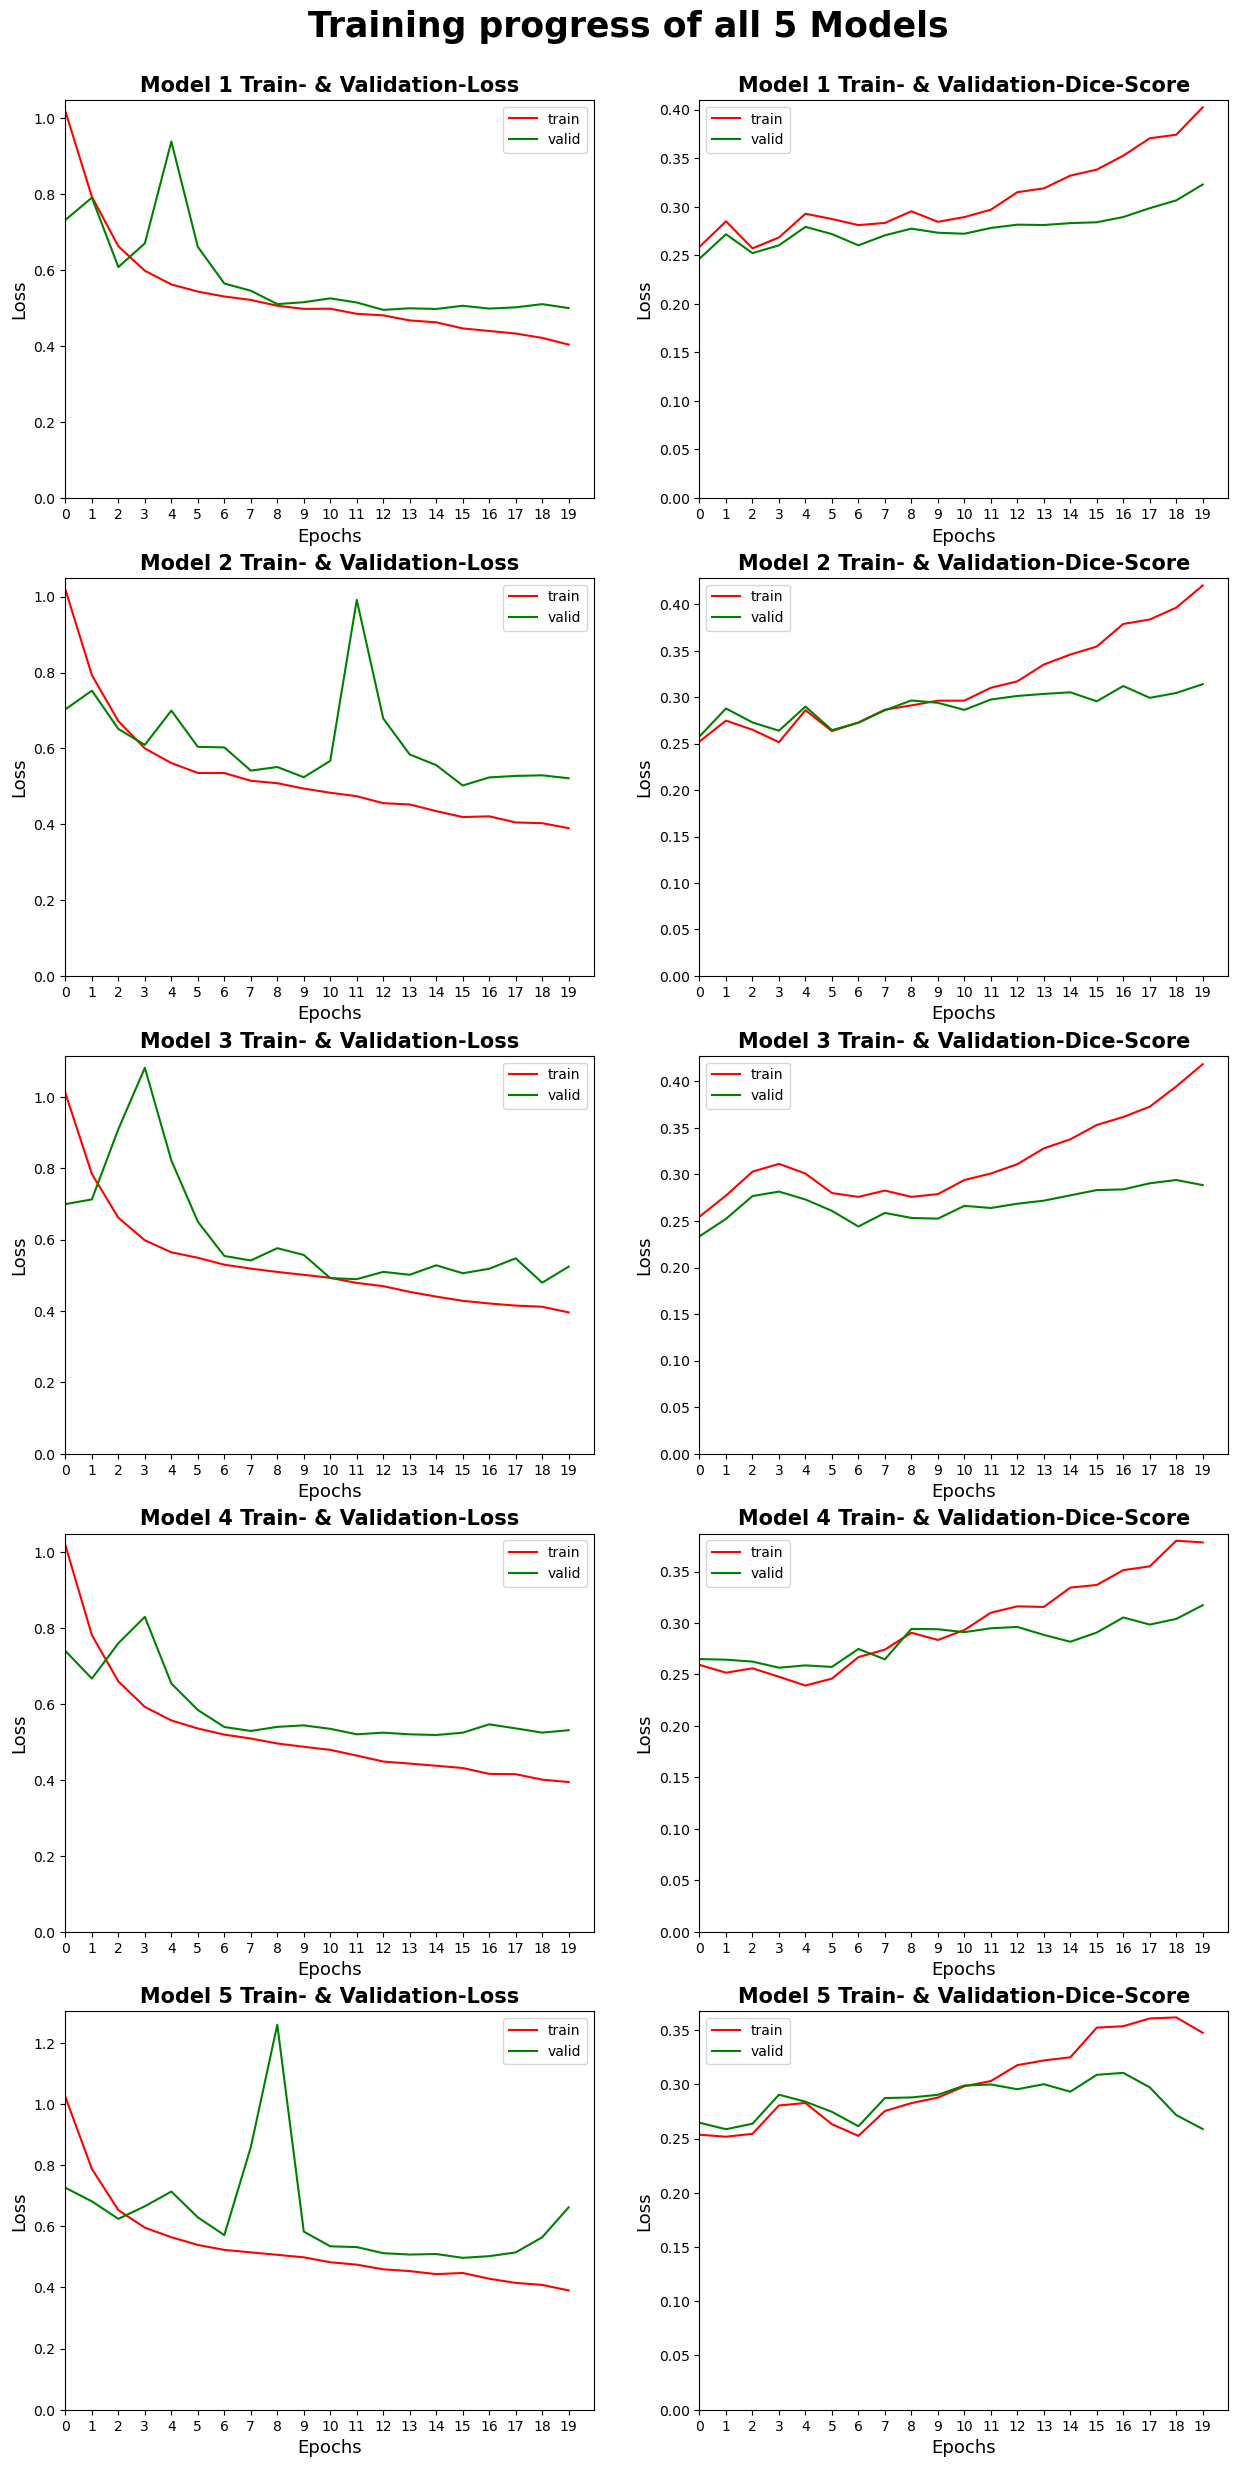

In [33]:
plot_results()